In [1]:
import gym
import matplotlib.pyplot as plt

In [2]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
import io
import glob
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(ipythondisplay.HTML(data="""
            <video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>
        """.format(encoded.decode('ascii'))))
    else:
        print('Could not find video')
    

def wrap_env(env):
  env = gym.wrappers.Monitor(env, './video', force=True)
  return env

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
from collections import deque
from tqdm.notebook import tqdm

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
class QNetwork(nn.Module):
    def __init__(self, num_frames, num_actions):
        super(QNetwork, self).__init__()

        # TODO: we use grayscale images, so each input channel is a single frame
        self.cnn = nn.Sequential(
            nn.Conv2d(num_frames, 32, 8, stride=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU()
        )

        self.output = nn.Sequential(
            nn.Linear(128 * 23 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )
        
    def forward(self, x):
        fmap = self.cnn(x)
        fmap = fmap.view(-1, 128 * 23 * 16)
        return self.output(fmap)       


class Agent(object):
    def __init__(self, *, action_space, num_frames, gamma, epsilon, min_eps,
                 eps_decay, lr, max_mem_size):
        
        self.action_space = action_space
        self.num_frames = num_frames
        self.num_actions = len(action_space)
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_eps = min_eps
        self.eps_decay = eps_decay
        self.lr = lr
        
        self.max_mem_size = max_mem_size
        self.memory = deque([], maxlen=max_mem_size)

        # hardcode up to 9 actions... for now
        self.dqn = QNetwork(num_frames, num_actions=9)

        self.loss_fn = nn.MSELoss()
        # self.loss_fn = nn.SmoothL1Loss()
        self.opt = torch.optim.Adam(self.dqn.parameters(), lr=lr)

    def ready_to_learn(self):
        return len(self.memory) == self.max_mem_size

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, observation):
        with torch.no_grad():
            if random.random() < self.epsilon:
                return random.choice(self.action_space)
            else:
                o = torch.tensor(observation).unsqueeze(0)
                q_values = self.dqn.forward(o).squeeze(0)
                return torch.argmax(q_values[:self.num_actions]).item()

    def learn(self, batch_size):
        if not self.ready_to_learn():
            return 0

        self.opt.zero_grad()

        mem_slice = random.sample(self.memory, batch_size)
        state, action, reward, next_state, done = map(torch.tensor, zip(*mem_slice))
        done = 1.0 * done

        q_values = self.dqn.forward(state)
        next_q_values = self.dqn.forward(next_state)

        q_value = q_values[torch.arange(batch_size), action]
        next_q_value = next_q_values[:, :self.num_actions].max(dim=1)[0]

        expected_q_value = reward + self.gamma * next_q_value * (1.0 - done)

        loss = self.loss_fn(q_value, expected_q_value)
        loss.backward()
        self.opt.step()

        # decay epsilon
        self.epsilon = max(self.min_eps, self.epsilon * self.eps_decay)
        return loss.detach()


In [5]:
def main_loop(agent, env, num_frames=3, batch_size=16, render=False):
    for i in range(20):
        observation = env.reset()
        prev_state = None
        frames = deque(maxlen=num_frames)
        score = [(0, 0)]
        loss = []

        for t in tqdm(range(10000)):
            if render:
                env.render()

            if prev_state is not None and agent.ready_to_learn():
                loss.append((t, agent.learn(batch_size)))
                action = agent.get_action(prev_state)
            else:
                action = env.action_space.sample()
        
            observation, reward, done, info = env.step(action)
            score.append((t, score[-1][1] + reward))
            frames.append(observation.mean(axis=2).astype(np.float32))

            # TODO: make the penalty for losing really bad
            if done:
                reward -= 0
                # reward -= 100
            
            if len(frames) == num_frames:
                state = np.stack(frames)
                if prev_state is not None:
                    agent.store_transition(prev_state, action, reward, state, done)
                prev_state = state

            if done:
                print(f'Episode finished after {t + 1} timesteps')
                break
            
        
        plt.title(f'episode {i} summary')
        plt.plot(*zip(*score), label='score')
        plt.ylabel('score')

        ax = plt.twinx()
        ax.plot(*zip(*loss), label='loss', color='orange')
        ax.set_ylabel('loss')

        plt.legend()
        plt.show()

In [6]:
render = True
save_video = False
game = 'Breakout-v0'
num_frames = 3

env = gym.make(game)
if save_video:
    env = wrap_env(env)

agent = Agent(
    action_space=range(env.action_space.n),
    num_frames=num_frames, gamma=0.99, epsilon=0.5, min_eps=0.01,
    eps_decay=0.999, lr=0.001, max_mem_size=10000
)

No handles with labels found to put in legend.


Episode finished after 168 timesteps



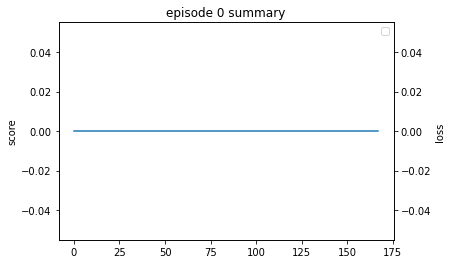

No handles with labels found to put in legend.


Episode finished after 190 timesteps



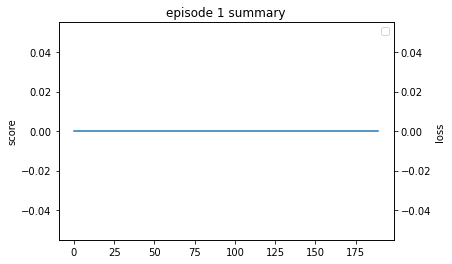

No handles with labels found to put in legend.


Episode finished after 278 timesteps



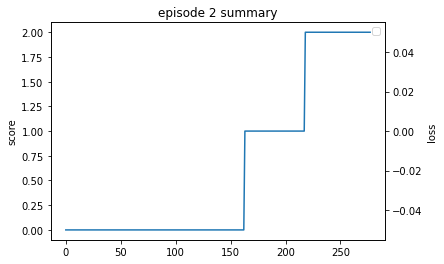

No handles with labels found to put in legend.


Episode finished after 286 timesteps



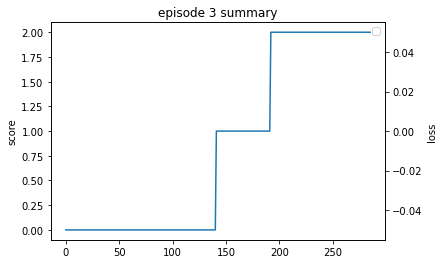

No handles with labels found to put in legend.


Episode finished after 319 timesteps



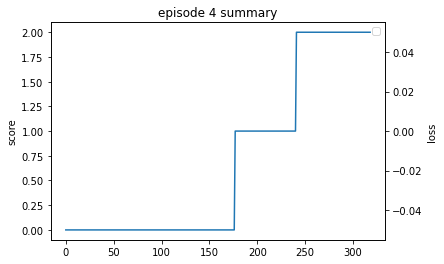

No handles with labels found to put in legend.


Episode finished after 366 timesteps



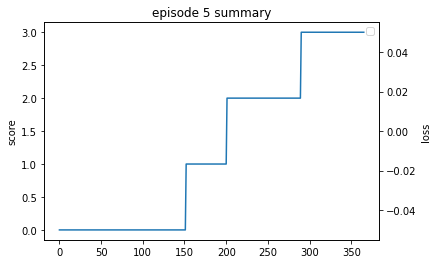

No handles with labels found to put in legend.


Episode finished after 242 timesteps



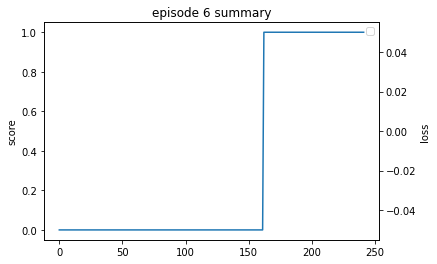

No handles with labels found to put in legend.


Episode finished after 287 timesteps



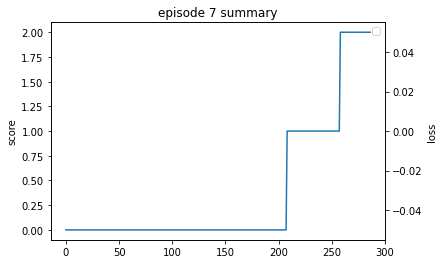

No handles with labels found to put in legend.


Episode finished after 215 timesteps



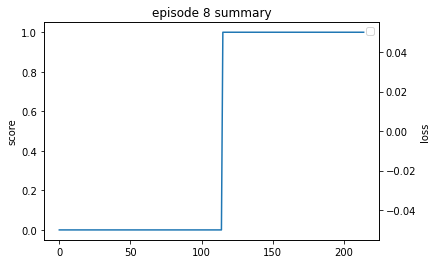

No handles with labels found to put in legend.


Episode finished after 397 timesteps



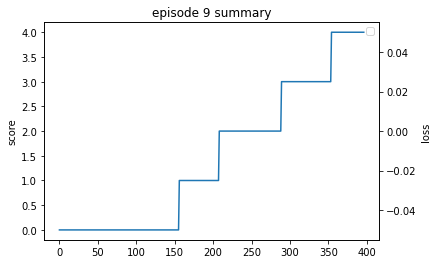

No handles with labels found to put in legend.


Episode finished after 354 timesteps



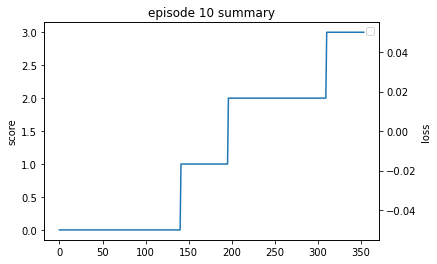

KeyboardInterrupt: 

In [7]:
main_loop(agent, env, num_frames=3, batch_size=16, render=render)
env.close()